# EBAnO - Explaining BlAck-box mOdel

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.python.keras.preprocessing import image
from tensorflow.keras.applications import vgg16, VGG16

In [2]:
def load_image(image_url, target_size):
    img = image.load_img(image_url, target_size=target_size)
    return img

def preprocess_function(img, model_preproc):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return model_preproc(x)

## Load the DCNN model of interest
EBAnO is compatible with any convolutional model developed with Keras. 

In [3]:
VGG16_model = VGG16(include_top=True, weights='imagenet', classes=1000)

target_size = VGG16_model._feed_input_shapes[0][1:3]
print("target_size:", target_size)
VGG16_model

target_size: (224, 224)


## Load an input image

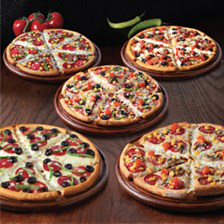

In [5]:
IMAGE_URL = "./data/pizza1.png"

input_image = load_image(IMAGE_URL, target_size)
input_image

## Predict classes for the input image

In [6]:
# Preprocess image
x = preprocess_function(input_image, vgg16.preprocess_input)

# Predict
predictions = VGG16_model.predict(x)

# Show top-10 predictions
top_preds = 10
decoded_predictions = vgg16.decode_predictions(predictions, top=top_preds)[0]
preds_indexes = np.argsort(predictions[0])[::-1][:top_preds] # Get indexes of top-10 predictions
pd.DataFrame(decoded_predictions, columns=["WNID", "Class name", "Prob."], index=preds_indexes).style.background_gradient()

,WNID,Class name,Prob.
455,n02877765,bottlecap,0.422296
963,n07873807,pizza,0.284991
415,n02776631,bakery,0.078728
927,n07613480,trifle,0.057947
532,n03201208,dining_table,0.028424
868,n04476259,tray,0.024669
746,n04019541,puck,0.016910
923,n07579787,plate,0.015435
762,n04081281,restaurant,0.012150
464,n02910353,buckle,0.007874


The VGG16 model predicted as most probable class *bottlecap*. Let's see why with EBAnO.

## Import EBAnO's Local Explanation Model
To explain a local prediction.

In [7]:
from ebano_express.explainer import LocalExplanationModel

### Why should it be a *bottlecap* ?

Get the local-explanation for the input image for class-of-interest *bottlecap* (i.e. class with id 455).

In [8]:
ebano_local_exp_bottlecap = LocalExplanationModel(input_image, 455,
                                        VGG16_model,
                                  preprocess_func=lambda x: preprocess_function(x, vgg16.preprocess_input),
                                  max_features=5,
                                  layers_to_analyze=5)

ebano_local_exp_bottlecap.fit_explanation(verbose=True)

> Computing explanation with '2' features...
> Computing explanation with '3' features...
> Computing explanation with '4' features...
> Computing explanation with '5' features...


It is possible to show the local explanation composed by:  
- Interpretable Features Map, 
- Visual Explanation
- Numerical Explanation

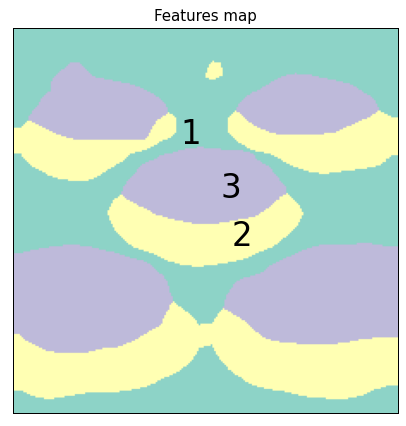

In [9]:
ebano_local_exp_bottlecap.best_explanation.show_features_map()
plt.show()
plt.close()

The Visual Explanation shows:  
- in GREEN the features that are positivelly influential for the class-of-interest
- in RED the features that are negativelly influential for the class-of-interesest

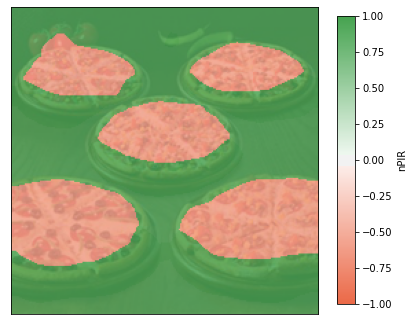

In [10]:
ebano_local_exp_bottlecap.best_explanation.show_visual_explanation()
plt.show()
plt.close()

The Numerical Explanation shows:  
- The nPIR values for each feature defining their positive or negative influence for the class-of-interest
- The nPIRP values for each feature describing how much they are precisely influential for the class-of-interest

The higher are the nPIR and nPIRP the most the feature is influential and precise for the class-of-interest.

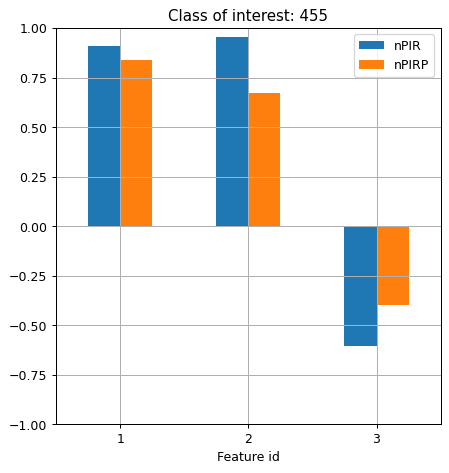

In [11]:
ebano_local_exp_bottlecap.best_explanation.show_numerical_explanation()
plt.show()
plt.close()

It is also possible to analyze the influence (nPIR) and influence precision (nPIRP) of each specific feature.  
In this case the table and the borders of the pizzas are both positivelly influential and precise for class-of-interest *bottlecap* causing the wrong prediction.

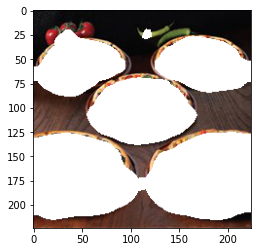

,1
nPIR,0.909206
nPIRP,0.836985


In [12]:
feature_img = ebano_local_exp_bottlecap.best_explanation.get_interpretable_feature(1)
plt.imshow(feature_img)
plt.show()
plt.close()

ebano_local_exp_bottlecap.best_explanation.get_numerical_explanation().loc[1, ["nPIR", "nPIRP"]].to_frame()


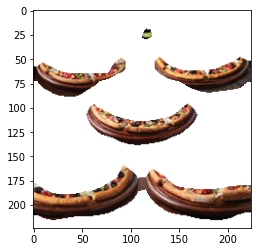

,2
nPIR,0.954937
nPIRP,0.669793


In [13]:
feature_img = ebano_local_exp_bottlecap.best_explanation.get_interpretable_feature(2)
plt.imshow(feature_img)
plt.show()
plt.close()

ebano_local_exp_bottlecap.best_explanation.get_numerical_explanation().loc[2, ["nPIR", "nPIRP"]].to_frame()

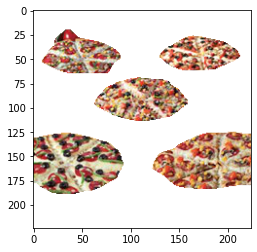

,3
nPIR,-0.606310
nPIRP,-0.397742


In [14]:
feature_img = ebano_local_exp_bottlecap.best_explanation.get_interpretable_feature(3)
plt.imshow(feature_img)
plt.show()
plt.close()

ebano_local_exp_bottlecap.best_explanation.get_numerical_explanation().loc[3, ["nPIR", "nPIRP"]].to_frame()

## Analyze the predicton preocess for a target class
Given a set of images with the same class-of-interest.

In [15]:
images_p = ["./data/pizza1.png",
            "./data/pizza2.png",
            "./data/pizza3.jpg"]
images = []
for im_p in images_p:
    im = load_image(im_p, target_size)
    images.append(im)

images

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7FF4D0C025F8>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7FF4D0C024A8>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7FF4D0C022B0>]

## Import EBAnO's Class-Global Explanation Model
To explain the prediction process for a specific class-of-interest model-wise.

In [16]:
from ebano_express.explainer import ClassGlobalExplanationModel

### Class-Global explanation for *pizza*

Get the class-based model explanation for the input images for class-of-interest *pizza* (i.e. class with id 963).

In [17]:
ebano_global_exp_pizza = ClassGlobalExplanationModel(images, 963,
                                               VGG16_model,
                                  preprocess_func=lambda x: preprocess_function(x, vgg16.preprocess_input),
                                  max_features=5,
                                  layers_to_analyze=5)


ebano_global_exp_pizza.fit_explanation()

Show the class-based model explanation for class-of-interest *pizza*. The features are distribuited on the nPIR X nPIRP space. The features related to the pizzas are grouped on the top-right section meaning that they are both positivelly influential and precise for *pizza*.

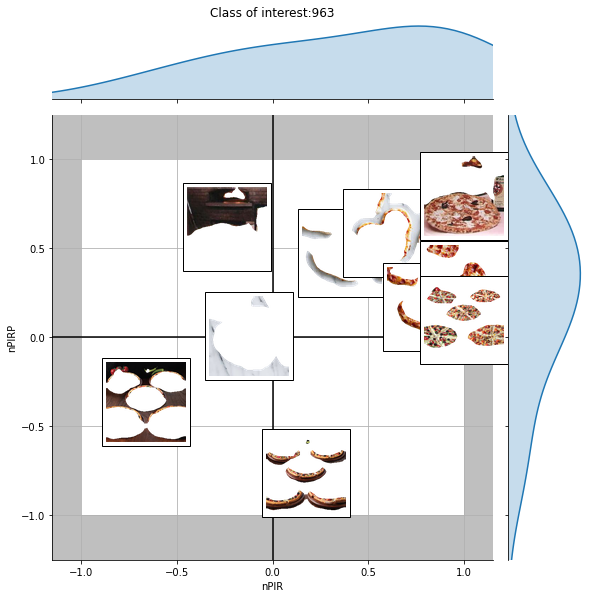

In [18]:
ebano_global_exp_pizza.show_global_explanation()
plt.show()
plt.close()

### Class-Global explanation for *bottlecap*
Get the class-based model explanation for the input images for class-of-interest *bottlecap* (i.e. class with id 455).

In [19]:
ebano_global_exp_bottlecap = ClassGlobalExplanationModel(images, 455,
                                               VGG16_model,
                                  preprocess_func=lambda x: preprocess_function(x, vgg16.preprocess_input),
                                  max_features=5,
                                  layers_to_analyze=5)


ebano_global_exp_bottlecap.fit_explanation()

Similarly, show the class-based model explanation for class-of-interest *bottlecap* to see if some bias is present or if the previous wrong prediction was an isolated case. So, from this class-based explanation we can conclude that it was an isolated case.

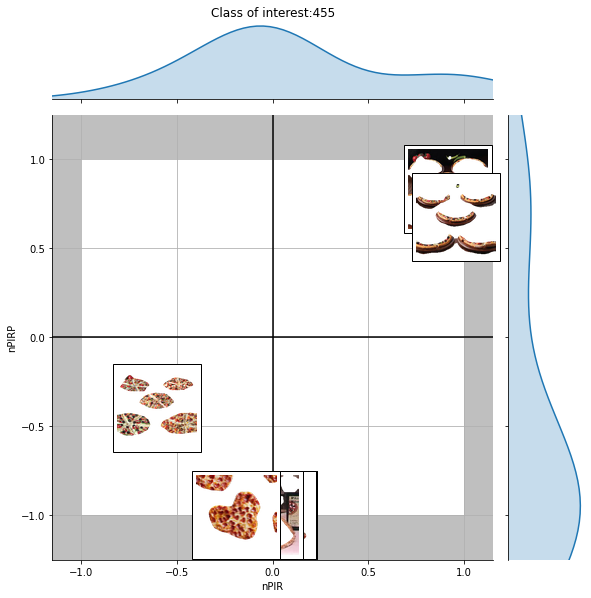

In [20]:
ebano_global_exp_bottlecap.show_global_explanation()
plt.show()
plt.close()